In [1]:
%load_ext autoreload
%autoreload

In [2]:
from utils_v1 import *


In [3]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import tracemalloc
import sys
import numpy as np
from src.dataset import (
    MultipleDates,
    PAMultipleDates,
    MTMultipleDates,
    MAMultipleDates,
    MSMultipleDates,
    PIMultipleDates,
    MOMultipleDates,
    L8MTMultipleDates,
    L8AMMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
from src.manager.multioutput import ManagerMCDropout, ManagerSingleRun, ManagerEnsemble, ManagerEvidential2
from src.Logger import Logger
import src.rasterTools as rasterTools



Tensorflow ver. 2.6.0


In [4]:
ic.configureOutput(includeContext=True)

In [5]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [6]:
config = {
	"training": False,
	"inferring": True,
	"site": "L8MT", # values: MT, PA, MS, PI
	"training_date": "earlier", # values: earlier, current
	"mode": "ensemble", # values: mcd, single_run, ensemble, evidential2
	"uncertainty_method": "pred_entropy", # pred_var MI pred_entropy KL pred_entropy_single
	"loadInference": False,
	"removePolygons": True,
	"plotLandsat": False,
	"plotPOI": False,

	"save_probabilities": False,
	"addPastDeforestationInput": True,
	"classes_mode": False,
	"learning_rate": 1e-4,
    "use_cloud_mask": False,
    "mask_out_non_biome": False,
	# "mask_out_no_data": True


	"georreferenced_save": True,
	"drop_no_data_pixels": True,
	"use_entire_image_as_training": False

}

In [7]:



if config['mode'] == 'mcd':
	managerClass = ManagerMCDropout
	config['inference_times'] = 10
	config['training_times'] = 1
elif config['mode'] == 'single_run':
	managerClass = ManagerSingleRun
	config['inference_times'] = 1
	config['training_times'] = 1
	config['uncertainty_method'] = 'pred_entropy_single'
elif config['mode'] == 'ensemble':
	managerClass = ManagerEnsemble
	config['inference_times'] = 10
	config['training_times'] = 10
elif config['mode'] == 'evidential2':
	managerClass = ManagerEvidential2
	config['inference_times'] = 1
	config['training_times'] = 1
else:
	raise ValueError('Invalid mode')

print(config)

if config['site'] == 'PA':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2017, 2018]
	else:
		dates = [2018, 2019]
	datasetClass = PAMultipleDates
elif config['site'] == 'MT':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]
	datasetClass = MTMultipleDates
elif config['site'] == 'MS':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
		# dates = [2019, 2020]

	else:
		dates = [2019, 2020]
		# dates = [2020, 2021]

	datasetClass = MSMultipleDates
elif config['site'] == 'PI':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
		# dates = [2017, 2018]

	else:
		dates = [2019, 2020]
		# dates = [2018, 2019]

	datasetClass = PIMultipleDates
	config['mask_out_non_biome'] = True
elif config['site'] == 'MO':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]
	datasetClass = MOMultipleDates
elif config['site'] == 'L8MT':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2021, 2022]
	else:
		dates = [2022, 2023]
		# dates = [2021, 2022]
	datasetClass = L8MTMultipleDates
elif config['site'] == 'L8AM':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2021, 2022]
	else:
		dates = [2022, 2023]
	datasetClass = L8AMMultipleDates

else:
	raise ValueError('Invalid site')

dataset = datasetClass(config = config,
			   dates = dates, 
	 	addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()



if config['training'] == False:

	if type(dataset) == PAMultipleDates:


		if config['training_date'] == 'current': exp = 0; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 1; repetition_id = 7
			exp = 20; repetition_id = 0
		 
	elif type(dataset) == MTMultipleDates:
		
		if config['training_date'] == 'current': exp = 2; repetition_id = 8
		elif config['training_date'] == 'earlier': exp = 3; repetition_id = 6		

	elif type(dataset) == MSMultipleDates:

		if config['training_date'] == 'current': exp = 4; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			# exp = 5; repetition_id = 0		
			# exp = 24; repetition_id = 0	
			# exp = 30; repetition_id = 0	# L1C
			exp = 37; repetition_id = 0	# L1C (New)
			
	elif type(dataset) == PIMultipleDates:

		if config['training_date'] == 'current': exp = 6; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 7; repetition_id = 0	
			## exp = 18; repetition_id = 0	
			exp = 27; repetition_id = 0 # L1C
			# exp = 28; repetition_id = 0 # L1C 2020
	elif type(dataset) == MOMultipleDates:

		if config['training_date'] == 'current': exp = 6; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 7; repetition_id = 0	
			exp = 19; repetition_id = 0	
	elif type(dataset) == L8MTMultipleDates:

		if config['training_date'] == 'current': exp = 38; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			
			exp = 38; repetition_id = 0	
	elif type(dataset) == L8AMMultipleDates:

		if config['training_date'] == 'current': exp = 38; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			
			exp = 39; repetition_id = 0	

else:

	exp = 39
	repetition_id = 0
	
logger = Logger()
manager = managerClass(config, dataset, patchesHandler, logger)
manager.defineExperiment(exp)


{'training': False, 'inferring': True, 'site': 'L8MT', 'training_date': 'earlier', 'mode': 'ensemble', 'uncertainty_method': 'pred_entropy', 'loadInference': False, 'removePolygons': True, 'plotLandsat': False, 'plotPOI': False, 'save_probabilities': False, 'addPastDeforestationInput': True, 'classes_mode': False, 'learning_rate': 0.0001, 'use_cloud_mask': False, 'mask_out_non_biome': False, 'georreferenced_save': True, 'drop_no_data_pixels': True, 'use_entire_image_as_training': False, 'inference_times': 10, 'training_times': 10}


ic| dataset.py:608 in __init__()- list(self.date_ids): [0]
ic| dataset.py:629 in __init__()
    self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
ic| patchesHandler.py:166 in __init__()- self.input_image_shape: 15
ic| patchesHandler.py:167 in __init__()
    self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]


In [8]:
'''
import src.Logger as lg
importlib.reload(lg)
logger = Logger()
manager.logger = logger
'''

'\nimport src.Logger as lg\nimportlib.reload(lg)\nlogger = Logger()\nmanager.logger = logger\n'

In [9]:
dates

[2022, 2023]

In [10]:
manager.config

{'training': False,
 'inferring': True,
 'site': 'L8MT',
 'training_date': 'earlier',
 'mode': 'ensemble',
 'uncertainty_method': 'pred_entropy',
 'loadInference': False,
 'removePolygons': True,
 'plotLandsat': False,
 'plotPOI': False,
 'save_probabilities': False,
 'addPastDeforestationInput': True,
 'classes_mode': False,
 'learning_rate': 0.0001,
 'use_cloud_mask': False,
 'mask_out_non_biome': False,
 'georreferenced_save': True,
 'drop_no_data_pixels': True,
 'use_entire_image_as_training': False,
 'inference_times': 10,
 'training_times': 10,
 'dropout_training': False}

In [11]:
exp

38

In [12]:
manager.setExperimentPath()
manager.createLogFolders()

In [13]:
# ic(type(dataset), exp, dataset.dates)


In [14]:

manager.loadLabel()

D:/Jorge/datasets/deforestation/L8MT/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:706 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021, 2022], dtype=uint16),
                                                              array([55051468,   444649,   152658,    82971,   171126,   126305,
                                                                      150003,   192518,   159550,   288068,   198611,   200406,
                                                                      423015,   230881,   374331,   440761], dtype=int64))


Label where deforestation past years is actual date (2023) = 1


ic| dataset.py:709 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021, 2022], dtype=uint16),
                                                              array([55051468,   444649,   152658,    82971,   171126,   126305,
                                                                      150003,   192518,   159550,   288068,   198611,   200406,
                                                                      423015,   230881,   374331,   440761], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:713 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021, 2022], dtype=uint16),
                                                              array([55051468,   444649,   152658,    82971,   171126,   126305,
                                                                      150003,   192518,   159550,   288068,   198611,   200406,
                                                                      423015,   230881,   374331,   440761], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/L8MT/deforestation_before_2008_L8MT.tif


ic| dataset.py:717 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([39949467, 18737854], dtype=int64))
ic| dataset.py:719 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021, 2022], dtype=uint16),
                                                              array([55051468,   444649,   152658,    82971,   171126,   126305,
                                                                      150003,   192518,   159550,   288068,   198611,   200406,
                                                                      423015,   230881,   374331,   440761], dtype=int64))
ic| dataset.py:698 in loadLabel()
    label_per_date.shape: (7721, 7601, 1)


Removing bufer................
Mask label shape:  
 (7721, 7601, 1) 
 Unique values:  
 [0 2]


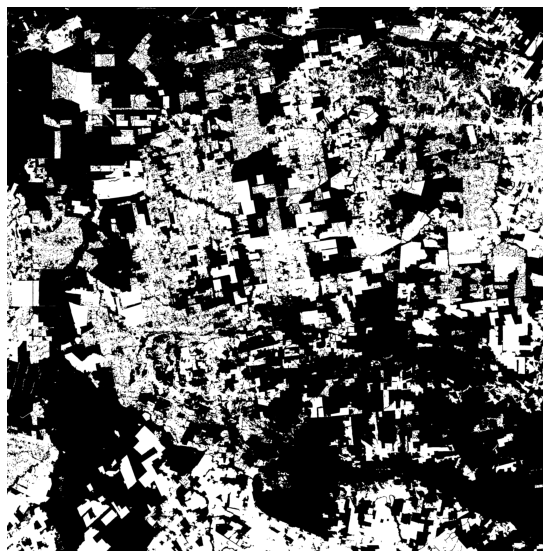

In [15]:
manager.logger.plotFigure(manager.label_mask, 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [16]:

# Creating tile mask
manager.createTrainValTestTiles()


Tiles size:  1544 1520
Mask size:  (7720, 7600)


In [17]:
def get_pixel_count_set(label, mask, set_id):
    label_set = label[mask == set_id]
    return np.unique(label_set, return_counts=True)


In [18]:

np.unique(manager.mask_tiles)
for set_id in np.unique(manager.mask_tiles):
    print('Set', set_id, get_pixel_count_set(manager.label_mask, manager.mask_tiles, set_id))


Set 1 (array([0, 2], dtype=uint8), array([1783471,  563409], dtype=int64))
Set 2 (array([0, 2], dtype=uint8), array([1934604,  412276], dtype=int64))
Set 3 (array([0, 2], dtype=uint8), array([1505129,  841751], dtype=int64))
Set 4 (array([0, 2], dtype=uint8), array([1501439,  845441], dtype=int64))
Set 5 (array([0, 2], dtype=uint8), array([1473500,  873380], dtype=int64))
Set 6 (array([0, 2], dtype=uint8), array([1807618,  539262], dtype=int64))
Set 7 (array([0, 2], dtype=uint8), array([1064762, 1282118], dtype=int64))
Set 8 (array([0, 2], dtype=uint8), array([1100335, 1246545], dtype=int64))
Set 9 (array([0, 2], dtype=uint8), array([1289889, 1056991], dtype=int64))
Set 10 (array([0, 2], dtype=uint8), array([ 903429, 1443451], dtype=int64))
Set 11 (array([0, 2], dtype=uint8), array([1206729, 1140151], dtype=int64))
Set 12 (array([0, 2], dtype=uint8), array([1024329, 1322551], dtype=int64))
Set 13 (array([0, 2], dtype=uint8), array([1160039, 1186841], dtype=int64))
Set 14 (array([0, 2],

In [19]:

manager.label_mask.dtype

dtype('uint8')

In [20]:

manager.getLabelCurrentDeforestation()

In [21]:

manager.loadInputImage()

ic| dataset.py:649 in loadInputImage()
    image_stack.shape: (7721, 7601, 15)


Image shape:  (7721, 7601, 15)
mask:  (7720, 7600)
image stack:  (7720, 7600, 15)
ref : (7720, 7600, 1)


self.image_stack.shape (7720, 7600, 15)


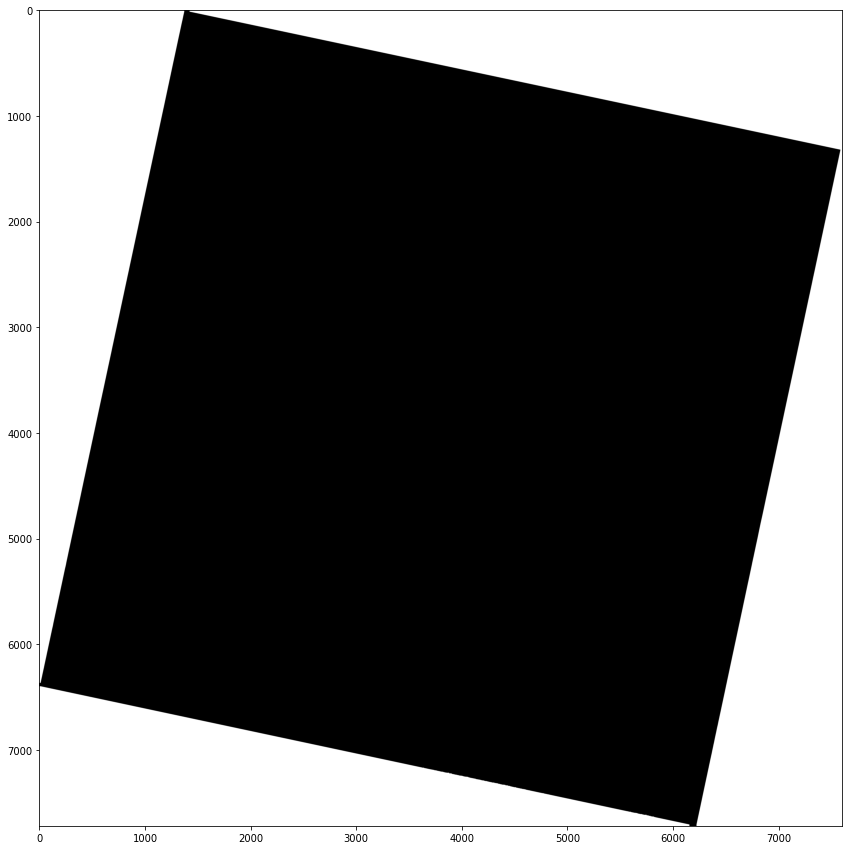

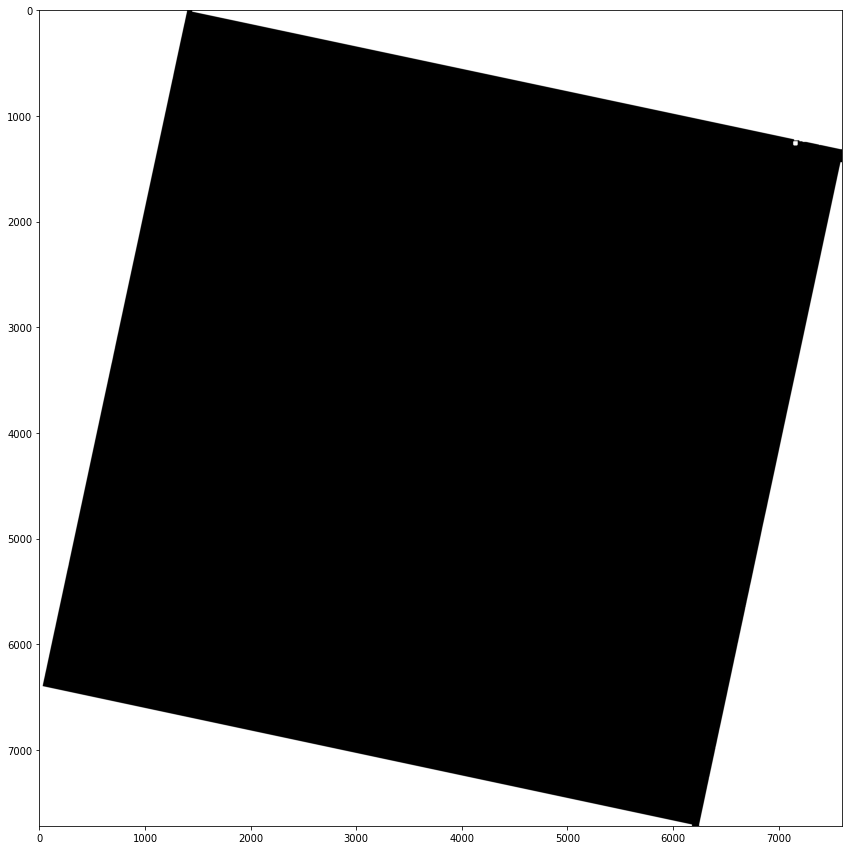

In [22]:
if config['drop_no_data_pixels'] == True:
    manager.maskNoDataAsNotConsideredClass()

In [23]:
manager.dataset.previewBandsSnip

[[3, 2, 1], [10, 9, 8]]

In [24]:
condition = np.squeeze(np.zeros_like(manager.label_mask))


In [25]:
condition.shape

(7720, 7600)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


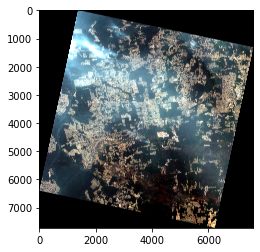

In [26]:
plt.imshow(manager.image_stack[...,[3,2,1]])

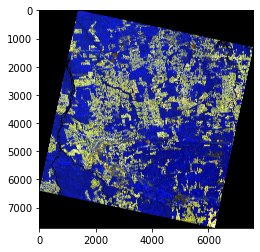

In [27]:
plt.imshow(manager.image_stack[...,[7,6,5]])

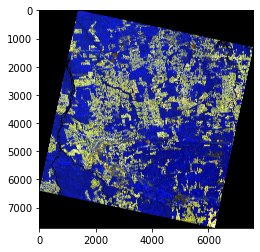

In [28]:
plt.imshow(manager.image_stack[...,[7,6,5]])

In [29]:

np.unique(manager.image_stack[...,0], return_counts=True)

(array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
        1.    ], dtype=float32),
 array([36306562,   440744,   374312,   230856,   423015,   200400,
          198605,   288024,   159550,   192518,   149986,   126305,
          171126,    82971,   152631,   444592, 18729803], dtype=int64))

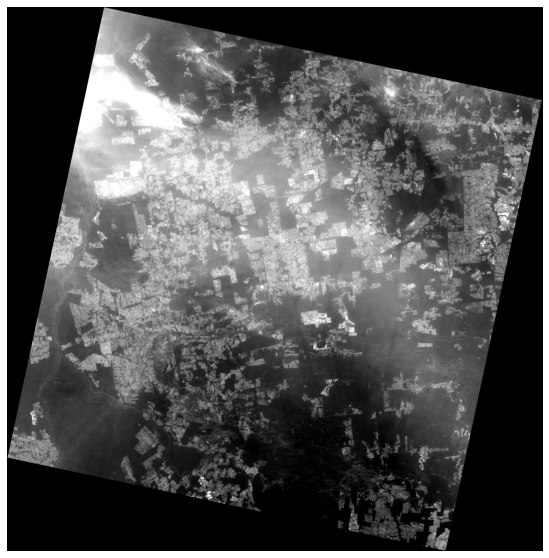

In [30]:

manager.logger.plotFigure(manager.image_stack[...,1], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

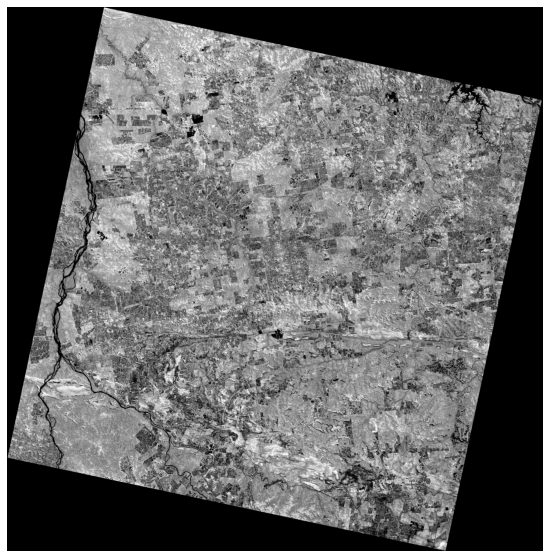

In [31]:

manager.logger.plotFigure(manager.image_stack[...,5], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

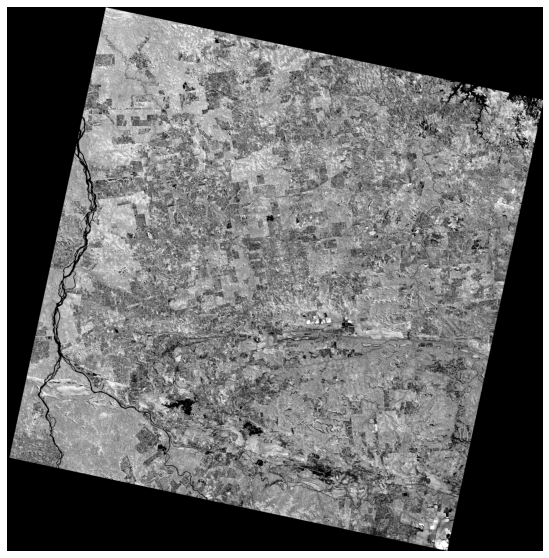

In [32]:

manager.logger.plotFigure(manager.image_stack[...,-3], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [33]:
def save_georreferenced(im, original_im_path, produced_im_path, bands = 1, plot = False):
    if len(im.shape) == 2:
        pad_values = ((0, 0), (0, 1))
    else:
        pad_values = ((0, 0), (0, 1), (0, 0))
    im_pad = np.pad(im, pad_values)
    print("im_pad.shape", im_pad.shape)

    if plot == True:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im_pad, cmap='jet')
        plt.axis('off')

    if len(im_pad.shape) == 2:
        im_pad = np.expand_dims(im_pad, axis=0)
    else:
        im_pad = np.transpose(im_pad, (2, 0, 1))
    print("im_pad.shape", im_pad.shape)

    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    im_pad.astype(np.float32), produced_im_path, bands = bands,
                    nodata=-1)
    del im_pad

In [34]:
import utils_v1
import rasterio

if config['georreferenced_save'] == True:
    # georref_im = utils_v1.load_tiff_image('D:/Jorge/datasets/sentinel2/MT_2019/S2_R1_MT_2019_08_02_2019_08_05_B3_B4.tif')
    original_im_path = os.path.join(manager.dataset.paths.optical_im_past_dates[2022], 
        manager.dataset.paths.im_filenames[2022][0])
    print("path",original_im_path)
    georref_im = utils_v1.load_tiff_image(original_im_path)

    print("georref_im.shape", georref_im.shape)

    del georref_im

path D:/Jorge/datasets/sentinel2/L8MT/2022\LC09_L1TP_228067_20220731_20230405_02_T1_B1.TIF
D:/Jorge/datasets/sentinel2/L8MT/2022\LC09_L1TP_228067_20220731_20230405_02_T1_B1.TIF
georref_im.shape (7721, 7601)


In [35]:
if config['georreferenced_save'] == True:

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_sentinel2_{}_rgb_georreferenced.tif'.format(
        manager.dataset.site, dates[0])
    print(produced_im_path)
    bands = manager.dataset.previewBandsSnip[0]
    save_georreferenced(manager.image_stack[...,bands], original_im_path, produced_im_path, bands = 3)

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_sentinel2_{}_rgb_georreferenced.tif'.format(
        manager.dataset.site, dates[1])
    print(produced_im_path)
    bands = manager.dataset.previewBandsSnip[1]
    save_georreferenced(manager.image_stack[...,bands], original_im_path, produced_im_path, bands = 3)


D:/Jorge/deforestation_uncertainty/georreferenced/L8MT_sentinel2_2022_rgb_georreferenced.tif
im_pad.shape (7720, 7601, 3)
im_pad.shape (3, 7720, 7601)
D:/Jorge/deforestation_uncertainty/georreferenced/L8MT_sentinel2_2023_rgb_georreferenced.tif
im_pad.shape (7720, 7601, 3)
im_pad.shape (3, 7720, 7601)


In [36]:
np.unique(manager.label_mask, return_counts=True)

(array([0, 2], dtype=uint8), array([25184357, 33487643], dtype=int64))

In [37]:
# manager.maskNoDataAsNotConsideredClass()

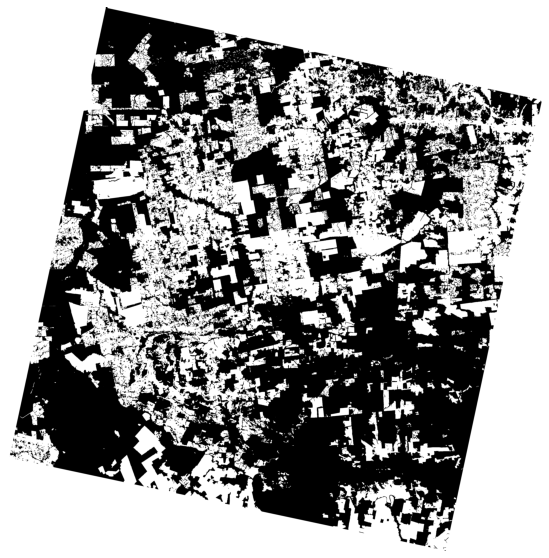

In [38]:

manager.logger.plotFigure(manager.label_mask, 
    name='label_mask', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [39]:

manager.getImageChannels()

ic| base.py:149 in getImageChannels()
    self.image_stack.shape: (7720, 7600, 15)
ic| base.py:151 in getImageChannels()- self.channels: 15


In [40]:

manager.getTrainValTestMasks()

Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [41]:
if config['use_entire_image_as_training'] == True:
    manager.mask_train_val[manager.mask_train_val == 0] = 1 # convert all test areas to train
    manager.mask_test[manager.mask_test == 1] = 0 # convert all test areas to train

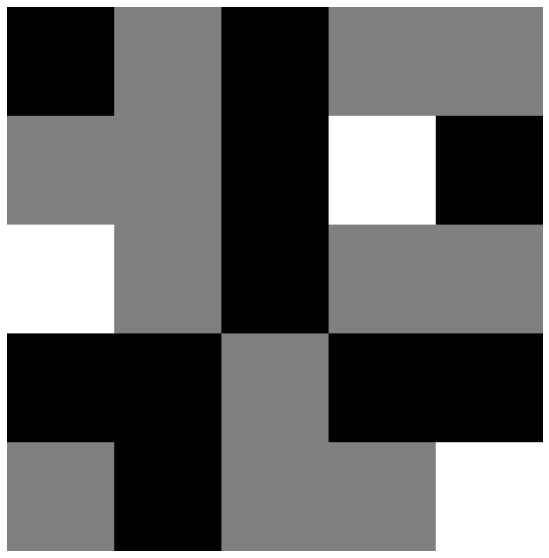

In [42]:
manager.logger.plotFigure(manager.mask_train_val, 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))


In [43]:

train_unique = get_pixel_count_set(manager.label_mask, manager.mask_train_val, 1)
val_unique = get_pixel_count_set(manager.label_mask, manager.mask_train_val, 2)
test_unique = get_pixel_count_set(manager.label_mask, manager.mask_train_val, 0)

total_unique = np.unique(manager.label_mask, return_counts=True)

In [44]:
print("train unique", train_unique)
print("val unique", val_unique)
print("test unique", test_unique)

print("total unique", total_unique)


train unique (array([0, 2], dtype=uint8), array([12074969, 16087591], dtype=int64))
val unique (array([0, 2], dtype=uint8), array([2566845, 4473795], dtype=int64))
test unique (array([0, 2], dtype=uint8), array([10542543, 12926257], dtype=int64))
total unique (array([0, 2], dtype=uint8), array([25184357, 33487643], dtype=int64))


In [45]:
print("train unique percentage", np.round(train_unique[1]/np.sum(train_unique[1]), 4))
print("val unique", np.round(val_unique[1]/np.sum(val_unique[1]), 4))
print("test unique", np.round(test_unique[1]/np.sum(test_unique[1]), 4))

train unique percentage [0.4288 0.5712]
val unique [0.3646 0.6354]
test unique [0.4492 0.5508]


In [46]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    manager.createIdxImage()


In [47]:
if config["training"] == True:
    manager.extractCoords()

In [48]:
if config["training"] == True:
    manager.trainTestSplit()

In [49]:
if config["training"] == True:
    manager.label_mask.shape

In [50]:
if config["training"] == True:

    manager.logger.plotFigure(manager.label_mask[...,-1], 
        name='Reference', cmap=plt.cm.gray, savefig=False)



In [51]:
if config["training"] == True:
    np.unique(manager.label_mask)

In [52]:
if config["training"] == True:
    print(manager.coords_train)

In [53]:
if config["training"] == True:
    manager.retrieveSamplesOfInterest()

In [54]:
if config["training"] == True:
    inputSnipShow = True

In [55]:
# count, unique = np.unique(label_mask, return_counts=True)
# print(count, unique)
# print(unique[1]/unique[0])

In [56]:
'''
count, unique = np.unique(label_mask[mask_test == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_test == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [57]:
'''
count, unique = np.unique(label_mask[mask_train_val == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_train_val == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [58]:
manager.dataset.image_channels

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]

In [59]:
manager.dataset.bands

7

In [60]:
manager.dataset.previewBandsSnip

[[3, 2, 1], [10, 9, 8]]

In [61]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 1000)


In [62]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 97)


In [63]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 500)

In [64]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [65]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [66]:
if config["training"] == True:
    manager.getGenerators()


In [67]:
if config["training"] == True:
    manager.fixChannelNumber()

In [68]:
if config["training"] == True:
    print(manager.path_exp)

In [69]:
if config["training"] == True:
    print(manager.channels)

In [70]:
if config["training"] == True:
    print(manager.image_stack.shape)

In [71]:
if config["training"] == True:
    print("config['training_times']", config["training_times"])

In [72]:
manager.class_n

3

In [73]:
if config["training"] == True:
    for tm in range(config['training_times']):
        manager.repetition_id = tm
        manager.train()

In [74]:
if config["training"] == True:
    manager.plotHistory()


In [75]:
repetition_id = 0

In [76]:
if config["inferring"] != True:
    sys.exit()
else:
    manager.repetition_id = repetition_id

In [77]:
manager.image_stack.shape

(7720, 7600, 15)

In [78]:
manager.patchesHandler.dataset.image_channels[-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [79]:
if issubclass(type(dataset), MultipleDates):
	manager.channels = manager.patchesHandler.input_image_shape
	manager.image_stack = manager.image_stack[..., manager.patchesHandler.dataset.image_channels[-1]]
	manager.label_mask = manager.label_mask[...,-1]


In [80]:
manager.image_stack.shape

(7720, 7600, 15)

In [81]:
manager.setPadding()

0.0 -16.0


In [82]:
import src.network as network
from tensorflow.keras.models import Model, load_model, Sequential
'''
def infer(self):

    self.h, self.w, self.c = self.image1_pad.shape
    self.c = self.channels
    patch_size_rows = self.h//self.n_rows
    patch_size_cols = self.w//self.n_cols
    num_patches_x = int(self.h/patch_size_rows)
    num_patches_y = int(self.w/patch_size_cols)

    ic(self.path_models+ '/' + self.method +'_'+str(self.repetition_id)+'.h5')
    model = load_model(self.path_models+ '/' + self.method +'_'+str(self.repetition_id)+'.h5', compile=False)
    
    if self.classes_mode == False:
        class_n = 3
        self.patchesHandler.class_n = class_n
    else:
        class_n = 2    
        self.patchesHandler.class_n = class_n + 1
    if self.config["loadInference"] == False:
        if self.config["save_probabilities"] == False:
            if self.classes_mode == False:
                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], self.config["inference_times"]), dtype = np.float32)
            else:
                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], class_n, self.config["inference_times"]), dtype = np.float32)

            # self.prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, self.config["inference_times"]), dtype = np.float32)
        print("Dropout training mode: {}".format(self.config['dropout_training']))
        new_model = network.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, self.c), 
            nb_filters = self.nb_filters, n_classes = class_n, dropout_seed = None, training=self.config['dropout_training'])

        for l in range(1, len(model.layers)):
            new_model.layers[l].set_weights(model.layers[l].get_weights())
        
        

        metrics_all =[]
        with tf.device('/cpu:0'):
            for tm in range(0,self.config["inference_times"]):

                print('time: ', tm)

                
                # Recinstructing predicted map
                start_test = time.time()
                
                prob_reconstructed = self.patchesHandler.infer(
                        new_model, self.image1_pad, self.h, self.w, 
                        num_patches_x, num_patches_y, patch_size_rows, 
                        patch_size_cols, classes_mode = self.classes_mode)
                        
                ts_time =  time.time() - start_test

                if self.config["save_probabilities"] == True:
                    np.save(self.path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
                else:
                    self.prob_rec[...,tm] = prob_reconstructed
                
                metrics_all.append(ts_time)
                del prob_reconstructed
            metrics_ = np.asarray(metrics_all)
            # Saving test time
            np.save(self.path_exp+'/metrics_ts.npy', metrics_)
    del self.image1_pad
'''

'\ndef infer(self):\n\n    self.h, self.w, self.c = self.image1_pad.shape\n    self.c = self.channels\n    patch_size_rows = self.h//self.n_rows\n    patch_size_cols = self.w//self.n_cols\n    num_patches_x = int(self.h/patch_size_rows)\n    num_patches_y = int(self.w/patch_size_cols)\n\n    ic(self.path_models+ \'/\' + self.method +\'_\'+str(self.repetition_id)+\'.h5\')\n    model = load_model(self.path_models+ \'/\' + self.method +\'_\'+str(self.repetition_id)+\'.h5\', compile=False)\n    \n    if self.classes_mode == False:\n        class_n = 3\n        self.patchesHandler.class_n = class_n\n    else:\n        class_n = 2    \n        self.patchesHandler.class_n = class_n + 1\n    if self.config["loadInference"] == False:\n        if self.config["save_probabilities"] == False:\n            if self.classes_mode == False:\n                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], self.config["inference_times"]), dtype = np.float32)\n            else:

In [83]:
'''
import types

manager.infer = types.MethodType(infer, manager)
'''


'\nimport types\n\nmanager.infer = types.MethodType(infer, manager)\n'

In [84]:
manager.infer()

time:  0
Loading model in: D:/Jorge/datasets/deforestation/experiments/L8MT/exp38/models/resunet_0.h5
runtime_repetition 20.82
time:  1
Loading model in: D:/Jorge/datasets/deforestation/experiments/L8MT/exp38/models/resunet_1.h5
runtime_repetition 22.88
time:  2
Loading model in: D:/Jorge/datasets/deforestation/experiments/L8MT/exp38/models/resunet_2.h5
runtime_repetition 23.35
time:  3
Loading model in: D:/Jorge/datasets/deforestation/experiments/L8MT/exp38/models/resunet_3.h5
runtime_repetition 23.07
time:  4
Loading model in: D:/Jorge/datasets/deforestation/experiments/L8MT/exp38/models/resunet_4.h5
runtime_repetition 23.16
time:  5
Loading model in: D:/Jorge/datasets/deforestation/experiments/L8MT/exp38/models/resunet_5.h5
runtime_repetition 23.44
time:  6
Loading model in: D:/Jorge/datasets/deforestation/experiments/L8MT/exp38/models/resunet_6.h5
runtime_repetition 23.33
time:  7
Loading model in: D:/Jorge/datasets/deforestation/experiments/L8MT/exp38/models/resunet_7.h5
runtime_r

In [85]:
manager.loadPredictedProbabilities()

In [86]:
manager.prob_rec.shape

(7720, 7616, 10)

In [87]:
'''
if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
'''

'\nif useLessInferenceRuns == True:\n    ic(reducedInferenceRuns)\n\n    prob_rec_all = prob_rec.copy()\n    prob_rec = prob_rec_all[:reducedInferenceRuns]\n    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))\n'

In [88]:
manager.prob_rec.shape

(7720, 7616, 10)

In [89]:
manager.getMeanProb()

In [90]:
manager.logger.getStats(manager.mean_prob)

ic| Logger.py:121 in getStats()
    np.min(value): 3.0042363e-23
    np.mean(value): 0.0036238802
    np.max(value): 0.99992275


In [91]:
ic(manager.mean_prob.shape)

ic| 3703776524.py:1 in <cell line: 1>()
    manager.

mean_prob.shape: (7720, 7616)


(7720, 7616)

In [92]:
manager.unpadMeanProb()

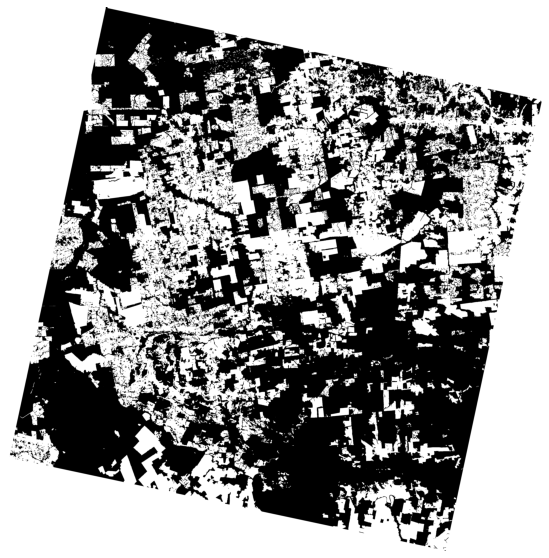

In [93]:
manager.logger.plotFigure(manager.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [94]:
manager.squeezeLabel()

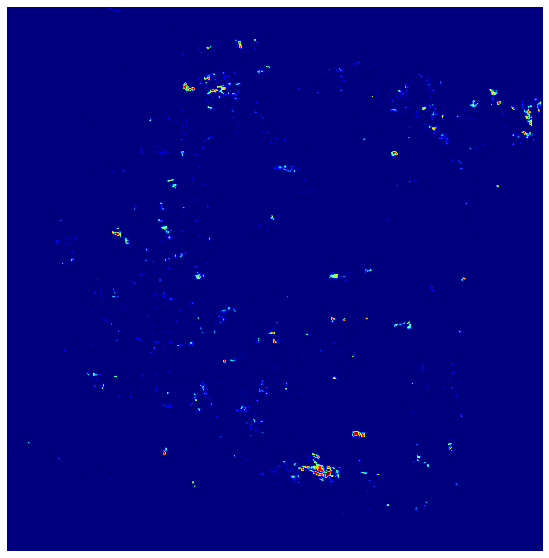

In [95]:
manager.setMeanProbNotConsideredAreas()
manager.logger.plotFigure(manager.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [96]:
print(manager.label_mask.shape)

(7720, 7600)


In [97]:
# manager.getLabelTest()

In [98]:
# manager.getMAP()

In [99]:
manager.prob_rec.shape

(7720, 7616, 10)

In [100]:
manager.preprocessProbRec()
print(manager.prob_rec.shape)

(10, 7720, 7616, 1)


In [101]:
manager.prob_rec.shape

(10, 7720, 7616, 1)

In [102]:
manager.logger.getStats(manager.prob_rec)

ic| Logger.py:121 in getStats()
    np.min(value): 0.0
    np.mean(value): 0.0036236795
    np.max(value): 0.99999845


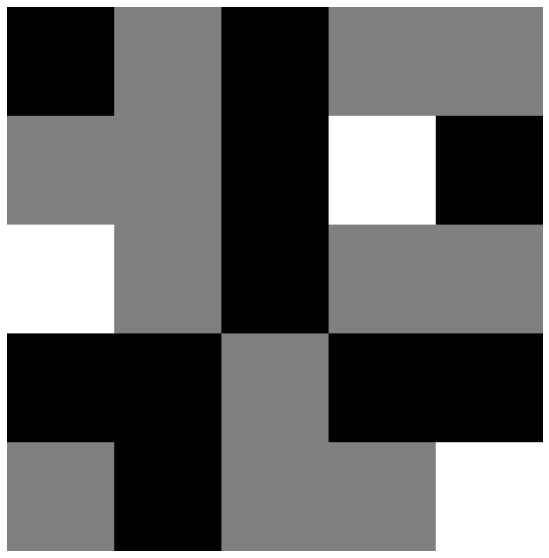

In [103]:
manager.logger.plotFigure(manager.mask_train_val, 
            name=manager.dataset.site + manager.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [104]:
manager.getLabelCurrentDeforestation()

In [105]:
manager.applyProbabilityThreshold()

(7720, 7600)


ic| base.py:451 in applyProbabilityThreshold()
    self.predicted_unpad.shape: (7720, 7600)
    self.predicted.shape: (7720, 7600)


(array([0., 1.], dtype=float32), array([58503200,   168800], dtype=int64))


In [106]:
manager.getTestValues()

ic| base.py:474 in getTestValues()- predicted_test.shape: (23468800,)
ic| base.py:483 in getTestValues()- predicted_test.shape: (10542543,)


In [107]:
manager.removeSmallPolygons()

ic| metrics.py:213 in removeSmallPolygonsForMetrics()
    np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([58503200,   168800], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([58513863,   158137], dtype=int64))
ic| metrics.py:215 in removeSmallPolygonsForMetrics()
    np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([58661337,    10663], dtype=int64))


In [108]:
manager.calculateMetrics()

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
ic| base.py:527 in calculateMetrics()
    self.f1: 0.0
    self.precision: 0.0
    self.recall: 0.0


In [109]:
manager.getValidationValuesForMetrics()
manager.calculateMetricsValidation()

ic| base.py:456 in getValidationValuesForMetrics()
    self.label_mask_val.shape: (7040640,)
ic| base.py:462 in getValidationValuesForMetrics()
    self.label_mask_val_valid.shape: (2566031,)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\_ranking.py:874: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
ic| base.py:538 in calculateMetricsValidation()
    f1_val: 0.0
    precision_val: 0.0
    recall_val: 0.0
    mAP_val: -0.0


In [110]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    manager.calculateMAPWithoutSmallPolygons()

In [111]:
manager.get_label_no_buffer()

D:/Jorge/datasets/deforestation/L8MT/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:706 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021, 2022], dtype=uint16),
                                                              array([55051468,   444649,   152658,    82971,   171126,   126305,
                                                                      150003,   192518,   159550,   288068,   198611,   200406,
                                                                      423015,   230881,   374331,   440761], dtype=int64))


Label where deforestation past years is actual date (2023) = 1


ic| dataset.py:709 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021, 2022], dtype=uint16),
                                                              array([55051468,   444649,   152658,    82971,   171126,   126305,
                                                                      150003,   192518,   159550,   288068,   198611,   200406,
                                                                      423015,   230881,   374331,   440761], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:713 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021, 2022], dtype=uint16),
                                                              array([55051468,   444649,   152658,    82971,   171126,   126305,
                                                                      150003,   192518,   159550,   288068,   198611,   200406,
                                                                      423015,   230881,   374331,   440761], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/L8MT/deforestation_before_2008_L8MT.tif


ic| dataset.py:717 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([39949467, 18737854], dtype=int64))
ic| dataset.py:719 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021, 2022], dtype=uint16),
                                                              array([55051468,   444649,   152658,    82971,   171126,   126305,
                                                                      150003,   192518,   159550,   288068,   198611,   200406,
                                                                      423015,   230881,   374331,   440761], dtype=int64))
ic| dataset.py:698 in loadLabel()
    label_per_date.shape: (7721, 7601, 1)


In [112]:
manager.getErrorMask()

(array([0., 1.], dtype=float32), array([58513863,   158137], dtype=int64))


In [113]:
manager.getErrorMaskToShowRGB()

[0. 1.]


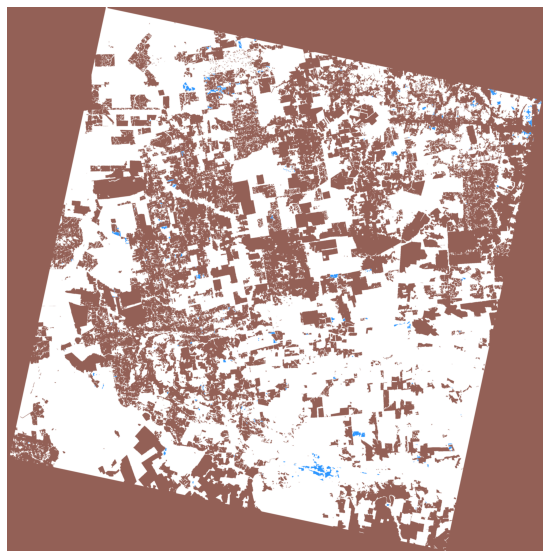

In [114]:
manager.logger.plotFigure(manager.error_mask_to_show_rgb[...,::-1], 
            name=manager.dataset.site + manager.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [115]:
'''
import types

manager.setUncertainty = types.MethodType(setUncertainty, manager)
'''


'\nimport types\n\nmanager.setUncertainty = types.MethodType(setUncertainty, manager)\n'

In [116]:
manager.config['uncertainty_method']

'pred_entropy'

In [117]:
manager.config['uncertainty_method'] = "pred_entropy"


In [118]:
print(np.min(manager.prob_rec), np.mean(manager.prob_rec), np.max(manager.prob_rec))
print(np.std(manager.prob_rec))
print(manager.prob_rec.shape)

0.0 0.0036236795 0.99999845
0.049880918
(10, 7720, 7616, 1)


In [119]:
manager.setUncertainty()

pred_mean 3.0042363e-23 0.0036238802 0.99992275
K = 1, pred_mean shape (7720, 7616, 1)


In [120]:
# manager.uncertainty_map[manager.uncertainty_map>1] = 1

In [121]:
manager.logger.getStats(manager.uncertainty_map)

ic| Logger.py:121 in getStats()
    np.min(value): 1.0376265e-21
    np.mean(value): 0.0031226315
    np.max

(value): 0.36787948


In [122]:
manager.getUncertaintyToShow()
manager.logger.getStats(manager.uncertainty_to_show)


ic| Logger.py:121 in getStats()
    np.min(value): 0.0
    np.mean(value): 0.0027304662
    np.max(value): 0.36787948


ic| 3944692317.py:4 in <cell line: 4>()
    manager.uncertainty_to_show.shape: (7720, 7600)


(7720, 7600)

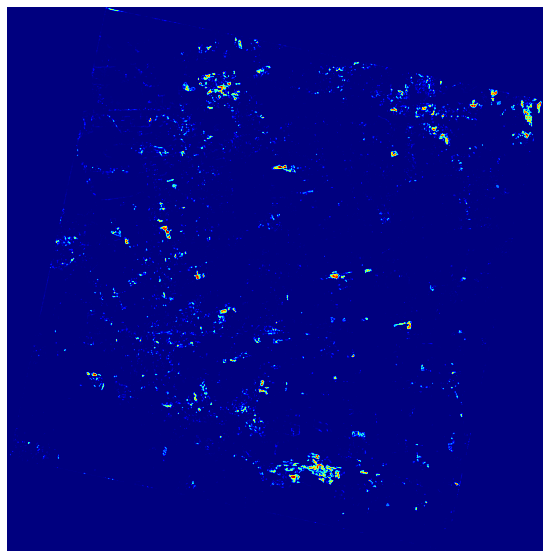

In [123]:

manager.logger.plotFigure(manager.uncertainty_to_show, 
            name=manager.dataset.site + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', figsize=(10,10), cmap='jet', savefig=True)

ic(manager.uncertainty_to_show.shape)



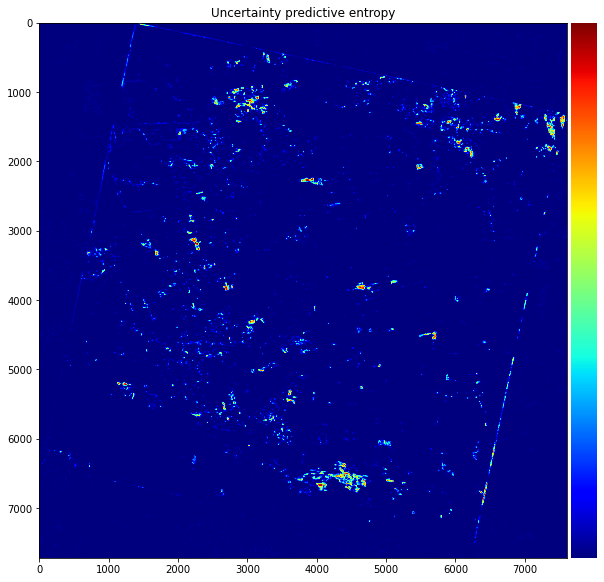

In [124]:

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(manager.uncertainty_map, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')

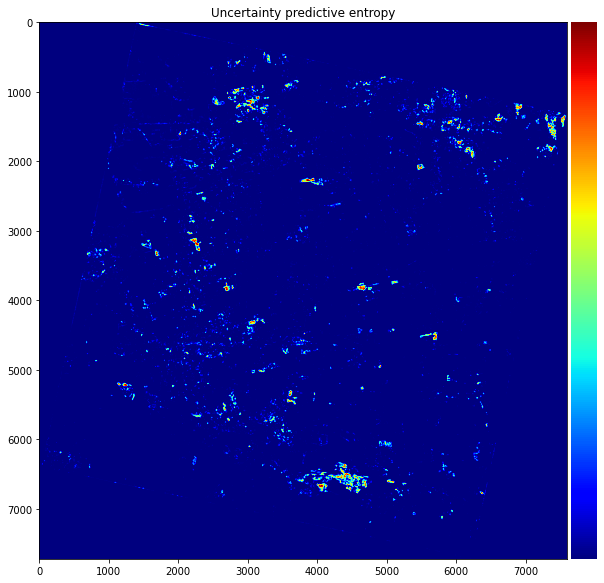

In [125]:

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(manager.uncertainty_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')

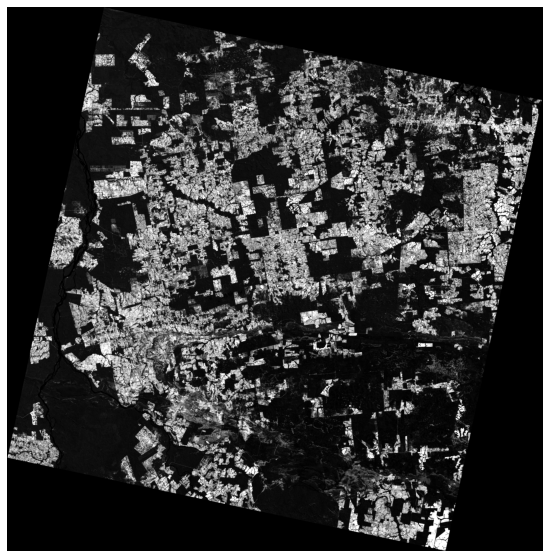

In [126]:

manager.logger.plotFigure(manager.image_stack[...,7], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [127]:
np.unique(manager.mask_train_val, return_counts=True)

(array([0, 1, 2], dtype=uint8),
 array([23468800, 28162560,  7040640], dtype=int64))

In [128]:
manager.error_mask.shape

(7720, 7600)

In [129]:
manager.npad

((0, 0), (0, 16), (0, 0))

In [130]:
manager.getValidationValues2()
manager.getTestValues2()

ic| base.py:578 in getTestValues2()
    self.label_mask.shape: (7720, 7600)
ic| base.py:579 in getTestValues2()
    self.mask_test.shape: (7720, 7600)
ic| base.py:583 in getTestValues2()
    self.label_mask_test.shape: (23468800,)


ic| base.py:591 in getTestValues2()
    self.error_mask_test.shape: (10538484,)


In [131]:
manager.dataset.previewLims1 = np.array([ 5500,  8500, 10000, 12500])

In [132]:
# manager.logger.plotCropSample(manager)

In [133]:
if config["plotLandsat"] == True:
    label_tmp_dates = []
    for date in dataset.prodes_dates:
        label_tmp_date = dataset.loadLabelFromDate(date)
        label_tmp_date = label_tmp_date[:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1]]
        label_tmp_dates.append(label_tmp_date)

In [134]:
if config["plotLandsat"] == True:
    # del manager.image_stack
    import src.lansdatLoader as ll
    import importlib
    importlib.reload(ll)
    landsatLoader = ll.LandsatLoader(dataset)
    ims = landsatLoader.load()
    for idx in range(len(ims)):
        ims[idx] = ims[idx][:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1],:]
    ims = landsatLoader.darken_past_deforestation(ims, manager.label_no_buffer)
    ims = landsatLoader.add_deforestation_edges_by_date(ims, label_tmp_dates[:])

In [135]:
if config["plotLandsat"] == True:
    logger.plotCropSampleLandsat(manager, ims)

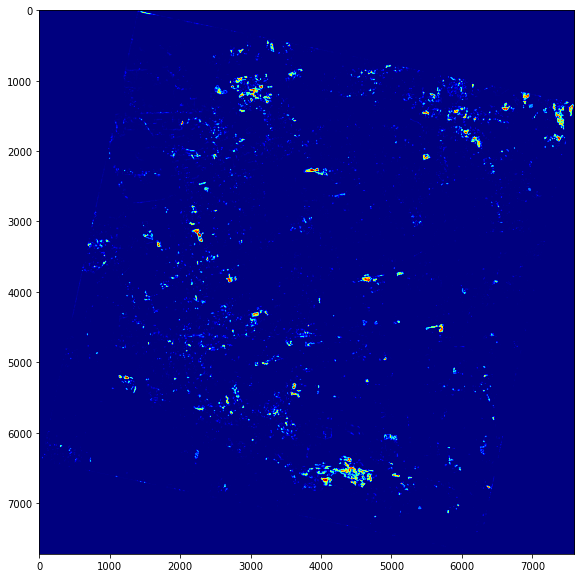

In [136]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.uncertainty_to_show, cmap = 'jet')


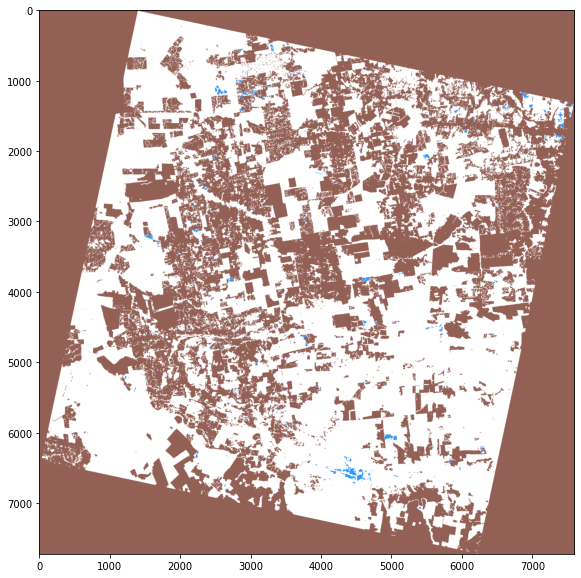

In [137]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.error_mask_to_show_rgb[...,::-1])


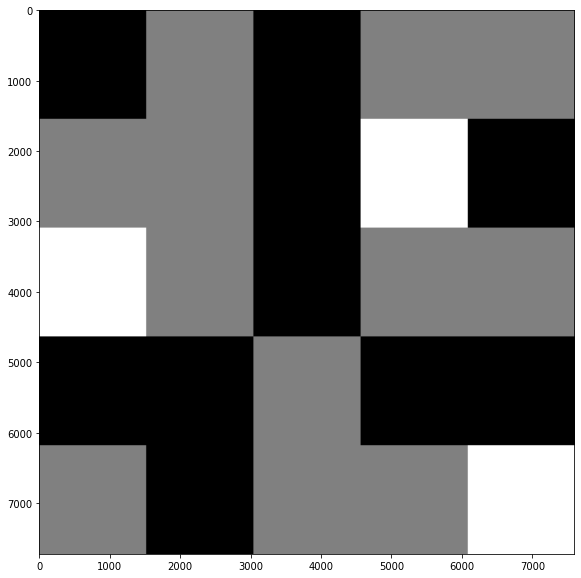

In [138]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.mask_train_val, cmap='gray')

In [139]:
manager.dataset.previewLims1 = np.array([230, 500, 2230, 2500])
manager.dataset.previewLims2 = np.array([12500, 15000, 15000, 17500])
manager.dataset.previewLims2 = np.array([4000, 5000, 18000, None])
manager.dataset.previewLims2 = np.array([3000, 7000, 16000, None])


# PI
manager.dataset.previewLims2 = np.array([5000, 7500, 12500, 15000])
manager.dataset.previewLims1 = np.array([17000, 18000, 5000, 7500])
manager.dataset.previewLims2 = np.array([5000, 7500, 10000, 12500])

# MA

manager.dataset.previewLims1 = np.array([17000, 18000, 6000, 7000])
manager.dataset.previewLims2 = np.array([12500, 15000, 2000, 3000])

# MS

manager.dataset.previewLims1 = np.array([15000, 17500, 5000, 7700])
manager.dataset.previewLims2 = np.array([12500, 15000, 2000, 3000])


In [140]:
manager.dataset.previewLims1 = np.array([15000, 17500, 12500, 15000])
# manager.dataset.previewLims2 = np.array([12500, 15000, 2000, 3000])


In [141]:
lims = manager.dataset.previewLims1
ic(np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]]))
lims = manager.dataset.previewLims2
ic(np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))


ic| 1025691406.py:2 in <cell line: 2>()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]]): array([], dtype=uint8)
ic| 1025691406.py:4 in <cell line: 4>()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([], dtype=uint8), array([], dtype=int64))


(array([], dtype=uint8), array([], dtype=int64))

In [142]:
'''
manager.dataset.previewLims1 = np.array([2500, 5000, 15000, 17500])
manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='0')
manager.dataset.previewLims1 = np.array([12500, 15000, 2500, 5000])
manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='1')
manager.dataset.previewLims1 = np.array([15000, 17500, 2000, 3000])
manager.dataset.previewLims1 = np.array([5000, 7500, 15000, 17500])

manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='2')
'''
# manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims2, colorbar=True, save_name='Colorbar')

"\nmanager.dataset.previewLims1 = np.array([2500, 5000, 15000, 17500])\nmanager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='0')\nmanager.dataset.previewLims1 = np.array([12500, 15000, 2500, 5000])\nmanager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='1')\nmanager.dataset.previewLims1 = np.array([15000, 17500, 2000, 3000])\nmanager.dataset.previewLims1 = np.array([5000, 7500, 15000, 17500])\n\nmanager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='2')\n"

In [143]:
manager.logger.getStats(manager.uncertainty)


ic| Logger.py:121 in getStats()
    np.min(value): 1.0376265e-21
    np.mean(value): 0.004563237
    np.max(value): 0.36787945


In [144]:
'''
manager.getOtherUncertaintyMetrics()
print(manager.sUEO)

print(manager.ece_score)  
'''

'\nmanager.getOtherUncertaintyMetrics()\nprint(manager.sUEO)\n\nprint(manager.ece_score)  \n'

In [145]:
if config["plotPOI"] == True and config['site'] == 'PA':

    print(manager.mean_prob.shape)
    font = {'family': "Times New Roman",
            'color':  'white',
            'weight': 'bold',
            'size': 24,
            }

    lims = dataset.previewLims1
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['A', 'B', 'C', 'D', 'E', 'F']

    for poi_id in range(4):
            
            plt.text(manager.dataset.snippet_coords['snippet_id0'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id0'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')

    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi0.png'), 
    dpi=150, bbox_inches='tight')

    lims = dataset.previewLims2
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['E', 'F']

    print(manager.dataset.snippet_coords['snippet_id1'])
    for poi_id in range(2):
            
            plt.text(manager.dataset.snippet_coords['snippet_id1'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id1'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')
            
    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi1.png'), 
    dpi=150, bbox_inches='tight')

In [146]:
if config["plotPOI"] == True and config['site'] == 'PA':
    manager.getPOIValues()


In [147]:

if config["plotPOI"] == True and config['site'] == 'PA':
    import pickle
    with open('output/log/log_ensemble_.pkl', 'wb') as f:
                pickle.dump(manager.snippet_poi_results, f)


In [148]:
from scipy import optimize  

manager.getOptimalUncertaintyThreshold(bounds=(np.min(manager.uncertainty) + 0.000015, np.max(manager.uncertainty) - 0.0015))

ic| base.py:829 in getOptimalUncertaintyThreshold()
    bounds: (1.5000000000000002e-05, 0.3663794503211975)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.1399537677530251
threshold 0.1399537677530251


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (126303,)
    predicted_test_classified_incorrect.shape: (126303,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 126303
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 126303
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.01198493 0.                nan
 0.1302125 ]
0.22644068256817235
threshold 0.22644068256817235


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (81817,)
    predicted_test_classified_incorrect.shape: (81817,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 81817
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 81817
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.00776364 0.                nan
 0.11514182]
0.08650191481514727
threshold 0.08650191481514727


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (169364,)
    predicted_test_classified_incorrect.shape: (169364,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 169364
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 169364
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.016071   0.                nan
 0.12769599]
0.05346685293787785
threshold 0.05346685293787785


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (214336,)
    predicted_test_classified_incorrect.shape: (214336,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 214336
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 214336
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.02033841 0.                nan
 0.11879342]
0.03305006187726943
threshold 0.03305006187726943


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (263223,)
    predicted_test_classified_incorrect.shape: (263223,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 263223
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 263223
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.02497731 0.                nan
 0.10843599]
0.02043179106060842
threshold 0.02043179106060842


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (316201,)
    predicted_test_classified_incorrect.shape: (316201,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 316201
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 316201
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.03000441 0.                nan
 0.09820934]
0.012633270816661019
threshold 0.012633270816661019


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (375871,)
    predicted_test_classified_incorrect.shape: (375871,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 375871
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 375871
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.03566652 0.                nan
 0.08797249]
0.023128130479262352
threshold 0.023128130479262352


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (302064,)
    predicted_test_classified_incorrect.shape: (302064,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 302064
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 302064
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.02866295 0.                nan
 0.1008593 ]
0.017453021389374632
threshold 0.017453021389374632


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (334903,)
    predicted_test_classified_incorrect.shape: (334903,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 334903
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 334903
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.03177905 0.                nan
 0.09483314]
0.02049332532393481
threshold 0.02049332532393481


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (315849,)
    predicted_test_classified_incorrect.shape: (315849,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 315849
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 315849
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.02997101 0.                nan
 0.09824837]
0.019294002290854463
threshold 0.019294002290854463


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (323004,)
    predicted_test_classified_incorrect.shape: (323004,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 323004
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 323004
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.03064995 0.                nan
 0.09700284]
0.020214797876329377
threshold 0.020214797876329377


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (317493,)
    predicted_test_classified_incorrect.shape: (317493,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 317493
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 317493
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.03012701 0.                nan
 0.09797741]
0.02039845742422265
threshold 0.02039845742422265


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (316396,)
    predicted_test_classified_incorrect.shape: (316396,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 316396
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 316396
    len(label_mask_current_deforestation_test): 10538484
ic| base.py:833 in getOptimalUncertaintyThreshold()
    self.threshold_optimal: 0.0204317910606

[0.                nan        nan 0.03002291 0.                nan
 0.09817051]


In [149]:
manager.getUncertaintyMetricsFromOptimalThreshold()

threshold:  0.02043179106060842
threshold 0.02043179106060842


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (316201,)
    predicted_test_classified_incorrect.shape: (316201,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 316201
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 316201
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.03000441 0.                nan
 0.09820934]
threshold 0.02043179106060842
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
ic| base.py:864 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_optimal: {'AA': array([0.03000441]),
                     'UEO': array([0.09820934]),
                     'f1': 0.0,
                     'f1_H': array([nan]),
                     'f1_L': array([nan]),
                     'precision_H': array([0.]),
                     'precision_L': array([0.]),
                     'recall_H': array([nan]),
                     'recall_L': array([nan]),
                     'recall_Ltotal': array([nan])}
ic| base.py:865 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_audited_optimal: {'f1': array([nan]), 'precision': array([0.]), 'recall': array([nan])}


cm_audited [[10531396     7088]
 [       0        0]]
[ 0. nan]


{'metrics': {'precision_L': array([0.]),
  'recall_L': array([nan]),
  'recall_Ltotal': array([nan]),
  'AA': array([0.03000441]),
  'precision_H': array([0.]),
  'recall_H': array([nan]),
  'UEO': array([0.09820934]),
  'f1_L': array([nan]),
  'f1_H': array([nan]),
  'f1': 0.0},
 'metrics_audited': {'precision': array([0.]),
  'recall': array([nan]),
  'f1': array([nan])},
 'exp': 38}

In [150]:
from src import metrics as _metrics

def getUncertaintyAAValues(self):



    # self.threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

    # self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
    if self.config['uncertainty_method'] == "pred_entropy_single":
        self.threshold_list = [0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    if self.config['uncertainty_method'] == "pred_entropy":
            if self.classes_mode == False:
                # self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                #            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                        0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]                            
                    # self.threshold_list = [0.0025, 0.025, 0.05, 0.1, 0.2, 0.4, 
                    #         0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            else:
                    self.threshold_list = [0.0025, 0.025, 0.05, 0.075, 0.1, 0.2, 0.4, 
                    0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                    
                    # self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    # 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
    elif self.config['uncertainty_method'] == "pred_var":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.13/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.0015, np.max(self.uncertainty)-0.0008]
            self.threshold_list = np.linspace(np.min(self.uncertainty) + 0.000015, np.max(self.uncertainty) - 0.0015, 19)
    elif self.config['uncertainty_method'] == "MI":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    elif self.config['uncertainty_method'] == "KL":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.006, np.max(self.uncertainty)-0.003]
    elif self.config['uncertainty_method'] == "evidential":
            # self.threshold_list = [0.015, 0.03, 0.04]
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            # self.threshold_list = [ 0.15, 0.2,  
            #          0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

            # self.threshold_list = [0.015,0.1, 0.2, 0.27, 0.36, 0.45, 0.55, 0.65]

            # self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                    
            # self.threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
    print(self.threshold_list)
    self.loadThresholdMetrics = False
    if self.loadThresholdMetrics == False:
            # self.threshold_list = [0.1]
            # y_test
            ic(self.uncertainty.shape, self.label_mask_current_deforestation_test.shape)

            metrics_values = _metrics.getAA_Recall(self.uncertainty, 
                    self.label_mask_current_deforestation_test, 
                    self.predicted_test, self.threshold_list)

            # ic(metrics_values)


    self.m = {'precision_L': metrics_values[:,0],
            'recall_L': metrics_values[:,1],
            'recall_Ltotal': metrics_values[:,2],
            'AA': metrics_values[:,3],
            'precision_H': metrics_values[:,4],
            'recall_H': metrics_values[:,5],
            'UEO': metrics_values[:,6]}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])


In [151]:

import types

manager.getUncertaintyAAValues = types.MethodType(getUncertaintyAAValues, manager)



Get precision-recall threshold

In [152]:

manager.getUncertaintyAAValues()

ic

[0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.3648794503211975, 0.3663794503211975]


| 321378179.py:65 in getUncertaintyAAValues()
    self.uncertainty.shape: (10538484,)
    self.label_mask_current_deforestation_test.shape: (10538484,)


threshold 0.005


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (511505,)
    predicted_test_classified_incorrect.shape: (511505,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 511505
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 511505
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.04853687 0.                nan
 0.07040218]
threshold 0.0075


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (449127,)
    predicted_test_classified_incorrect.shape: (449127,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 449127
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 449127
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.0426178  0.                nan
 0.07744706]
threshold 0.01


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (407555,)
    predicted_test_classified_incorrect.shape: (407555,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 407555
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 407555
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.03867302 0.                nan
 0.08306281]
threshold 0.015


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (353676,)
    predicted_test_classified_incorrect.shape: (353676,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 353676
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 353676
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.03356042 0.                nan
 0.09159019]
threshold 0.025


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (293201,)
    predicted_test_classified_incorrect.shape: (293201,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 293201
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 293201
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.02782193 0.                nan
 0.10249693]
threshold 0.05


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (221091,)
    predicted_test_classified_incorrect.shape: (221091,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 221091
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 221091
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.02097939 0.                nan
 0.11731102]
threshold 0.08


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (176569,)
    predicted_test_classified_incorrect.shape: (176569,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 176569
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 176569
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.01675469 0.                nan
 0.12637001]
threshold 0.1


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (156287,)
    predicted_test_classified_incorrect.shape: (156287,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 156287
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 156287
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.01483012 0.                nan
 0.12941129]
threshold 0.15


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (120112,)
    predicted_test_classified_incorrect.shape: (120112,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 120112
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 120112
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.01139746 0.                nan
 0.12958817]
threshold 0.2


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (93747,)
    predicted_test_classified_incorrect.shape: (93747,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 93747
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 93747
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.00889568 0.                nan
 0.12222269]
threshold 0.225


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (82446,)
    predicted_test_classified_incorrect.shape: (82446,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 82446
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 82446
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.00782333 0.                nan
 0.11555265]
threshold 0.25


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (71829,)
    predicted_test_classified_incorrect.shape: (71829,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 71829
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 71829
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.00681588 0.                nan
 0.10581852]
threshold 0.27


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (63415,)
    predicted_test_classified_incorrect.shape: (63415,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 63415
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 63415
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.00601747 0.                nan
 0.0945632 ]
threshold 0.3


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (50634,)
    predicted_test_classified_incorrect.shape: (50634,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 50634
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 50634
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.00480468 0.                nan
 0.07117459]
threshold 0.34


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (31765,)
    predicted_test_classified_incorrect.shape: (31765,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_L = TP_L / (TP_L + FN_L)
d:\Jorge\deforestation_uncertainty\src\metrics.py:298: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_H = TP_H / (TP_H + FN_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:300: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 31765
    len(label_mask_current_deforestation_test): 10538484
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 31765
    len(label_mask_current_deforestation_test): 10538484


[0.                nan        nan 0.00301419 0.                nan
 0.01476084]
threshold 0.36


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (16837,)
    predicted_test_classified_incorrect.shape: (16837,)
ic| metrics.py:277 in getAA_Recall()
    np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| metrics.py:278 in getAA_Recall()
    np.all(predicted_test_classified_incorrect) == 0: True


[       nan        nan        nan 0.00159767        nan        nan
        nan]
threshold 0.3648794503211975


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (10393,)
    predicted_test_classified_incorrect.shape: (10393,)
ic| metrics.py:277 in getAA_Recall()
    np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| metrics.py:278 in getAA_Recall()
    np.all(predicted_test_classified_incorrect) == 0: True


[       nan        nan        nan 0.00098619        nan        nan
        nan]
threshold 0.3663794503211975


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (7338,)
    predicted_test_classified_incorrect.shape: (7338,)
ic| metrics.py:277 in getAA_Recall()
    np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| metrics.py:278 in getAA_Recall()
    np.all(predicted_test_classified_incorrect) == 0: True


[       nan        nan        nan 0.00069631        nan        nan
        nan]


In [153]:
manager.getUncertaintyAAAuditedValues()

ic| base.py:720 in getUncertaintyAAAuditedValues()
    self.uncertainty.shape: (10538484,)
    self.label_mask_current_deforestation_test.shape: (10538484,)


threshold 0.005
(10538484,) (10538484,)
cm_audited [[10535843     2641]
 [       0        0]]
[ 0. nan]
threshold 0.0075
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10534721     3763]
 [       0        0]]
[ 0. nan]
threshold 0.01
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10533881     4603]
 [       0        0]]
[ 0. nan]
threshold 0.015
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10532580     5904]
 [       0        0]]
[ 0. nan]
threshold 0.025
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10530515     7969]
 [       0        0]]
[ 0. nan]
threshold 0.05
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10526937    11547]
 [       0        0]]
[ 0. nan]
threshold 0.08
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10523813    14671]
 [       0        0]]
[ 0. nan]
threshold 0.1
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10522004    16480]
 [       0        0]]
[ 0. nan]
threshold 0.15
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10517881    20603]
 [       0        0]]
[ 0. nan]
threshold 0.2
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10514086    24398]
 [       0        0]]
[ 0. nan]
threshold 0.225
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10512209    26275]
 [       0        0]]
[ 0. nan]
threshold 0.25
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10510236    28248]
 [       0        0]]
[ 0. nan]
threshold 0.27
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10508480    30004]
 [       0        0]]
[ 0. nan]
threshold 0.3
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10505591    32893]
 [       0        0]]
[ 0. nan]
threshold 0.34
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10500673    37811]
 [       0        0]]
[ 0. nan]
threshold 0.36
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10499646    38838]
 [       0        0]]
[ 0. nan]
threshold 0.3648794503211975
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)


cm_audited [[10499646    38838]
 [       0        0]]
[ 0. nan]
threshold 0.3663794503211975
(10538484,) (10538484,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
d:\Jorge\deforestation_uncertainty\src\metrics.py:353: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
ic| base.py:726 in getUncertaintyAAAuditedValues()
    metric_values_audited: array([[ 0., nan],
                                  [ 0., nan],
                                  [ 0., nan],
                                  [ 0., nan],
                                  [ 0., nan],
                                  [ 0., nan],
                                  [ 0., nan],
                                  [ 0., nan],
                                  [ 0., nan],
                                  [ 0., nan],
                                  [ 0., nan],
                                  [ 0., nan],
                                  [ 0., nan],
                                  [ 0., nan],
                   

cm_audited [[10499646    38838]
 [       0        0]]
[ 0. nan]


In [154]:
manager.setPlotLimsForUncertaintyAA()

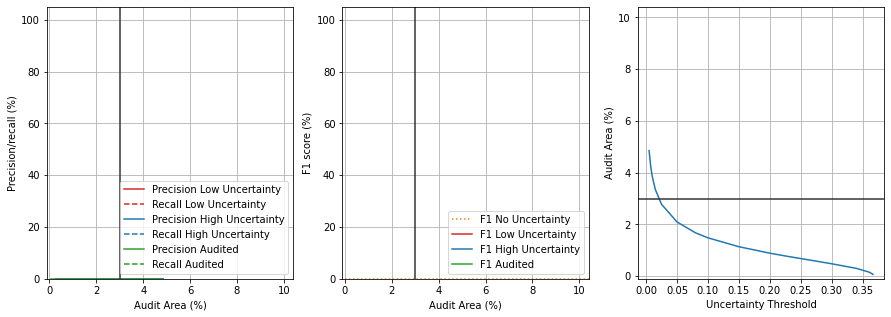

In [155]:
'''
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]
'''
manager.plotUncertaintyAA(normalize_xlim=False)

In [156]:
manager.dataset.paths.im_filenames[2022][0]
manager.dataset.paths.optical_im_past_dates[2022]

'D:/Jorge/datasets/sentinel2/L8MT/2022'

In [157]:
config['georreferenced_save'] = True

In [158]:
if config['georreferenced_save'] == True:
    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_uncertainty_georreferenced.tif'.format(
        manager.dataset.site)
    save_georreferenced(manager.uncertainty_to_show, original_im_path,produced_im_path)


im_pad.shape (7720, 7601)
im_pad.shape (1, 7720, 7601)


In [159]:
if config['georreferenced_save'] == True:
    predicted_to_show = manager.predicted_unpad.copy()
    predicted_to_show[manager.label_mask == 2] = 0 # 1 for deforestation. 0 for the rest

    false_positive_mask = predicted_to_show - manager.label_mask_current_deforestation # 0 for correct. 1 for false positive. -1 for false negative
    false_positive_mask = (false_positive_mask + 1).astype(np.int8) # 1 for correct. 2 for false positive. 0 for false negative
    del predicted_to_show
    ic(np.unique(false_positive_mask, return_counts=True))

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_false_positive_mask_georreferenced.tif'.format(
        manager.dataset.site)
    save_georreferenced(false_positive_mask, original_im_path,produced_im_path)

    del false_positive_mask


ic| 962672046.py:8 in <cell line: 1>()
    np.unique(false_positive_mask, return_counts=True): (array([1, 2], dtype=int8), array([58513863,   158137], dtype=int64))


im_pad.shape (7720, 7601)
im_pad.shape (1, 7720, 7601)


In [160]:
if config['georreferenced_save'] == True:
    predicted_georreferenced = manager.predicted_unpad.copy()
    predicted_georreferenced[manager.label_mask == 2] = 2 

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_predicted_georreferenced.tif'.format(
        manager.dataset.site)
    save_georreferenced(predicted_georreferenced, original_im_path,produced_im_path)
    del predicted_georreferenced


im_pad.shape (7720, 7601)
im_pad.shape (1, 7720, 7601)
